In [6]:
#import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    fbeta_score, precision_recall_curve, roc_curve
)
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [7]:
# load the data and preprocess it
def load_data(path):
    df = pd.read_csv(path)
    df.dropna(inplace=True)
    X = df.drop('Bleaching', axis=1)
    y = df['Bleaching'].astype(int)
    return X, y
def normalize_and_reshape(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_scaled, X_reshaped, scaler



In [9]:
#build the lstm model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


In [10]:
# plot the roc and precision recall curve
def plot_roc_pr(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(rec, prec)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_conf_matrix(cm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Bleach', 'Bleach'],
                yticklabels=['No Bleach', 'Bleach'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [18]:
#cross validation for the lstm model
def cross_validate_lstm(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_f2 = []
    all_auc = []
    all_best_thresh = []

    fold = 1
    for train_idx, val_idx in skf.split(X, y):
        print(f"\n--- Fold {fold} ---")
        fold += 1

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

        model = build_model(input_shape=(1, X_train.shape[2]))
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=50,
                  batch_size=32,
                  callbacks=[early_stop],
                  verbose=0)

        y_proba = model.predict(X_val).ravel()
        thresholds = np.linspace(0.1, 0.9, 81)
        f2_scores = [fbeta_score(y_val, y_proba > t, beta=2) for t in thresholds]
        best_thresh = thresholds[np.argmax(f2_scores)]

        y_pred = (y_proba > best_thresh).astype(int)
        cm = confusion_matrix(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        print(classification_report(y_val, y_pred))
        print(f"Best Threshold: {best_thresh:.2f}")
        print(f"F2 Score: {f2:.4f}")
        print(f"AUC Score: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)

        plot_roc_pr(y_val, y_proba)
        plot_conf_matrix(cm)

        all_f2.append(f2)
        all_auc.append(auc)
        all_best_thresh.append(best_thresh)

    print("\n=== Cross-Validation Summary ===")
    print(f"Avg F2: {np.mean(all_f2):.4f} ± {np.std(all_f2):.4f}")
    print(f"Avg AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")
    print(f"Best Thresholds: {np.round(all_best_thresh, 2)}")



--- Fold 1 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       123
           1       0.71      0.62      0.67         8

    accuracy                           0.96       131
   macro avg       0.85      0.80      0.82       131
weighted avg       0.96      0.96      0.96       131

Best Threshold: 0.19
F2 Score: 0.6410
AUC Score: 0.9522
Confusion Matrix:
[[121   2]
 [  3   5]]


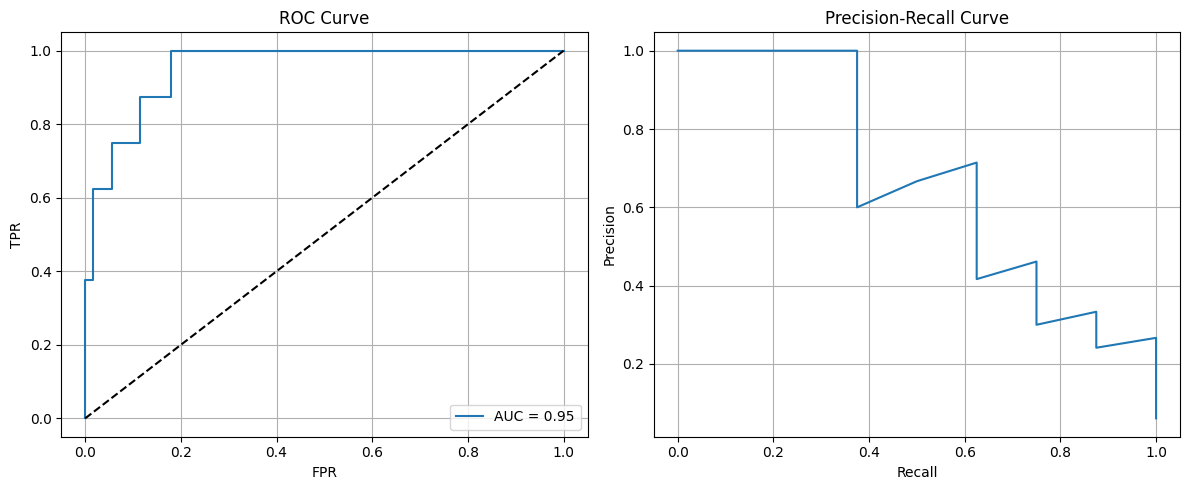

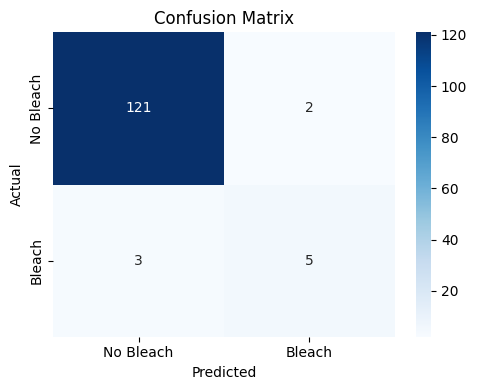


--- Fold 2 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       123
           1       0.54      0.88      0.67         8

    accuracy                           0.95       131
   macro avg       0.76      0.91      0.82       131
weighted avg       0.96      0.95      0.95       131

Best Threshold: 0.15
F2 Score: 0.7778
AUC Score: 0.9553
Confusion Matrix:
[[117   6]
 [  1   7]]


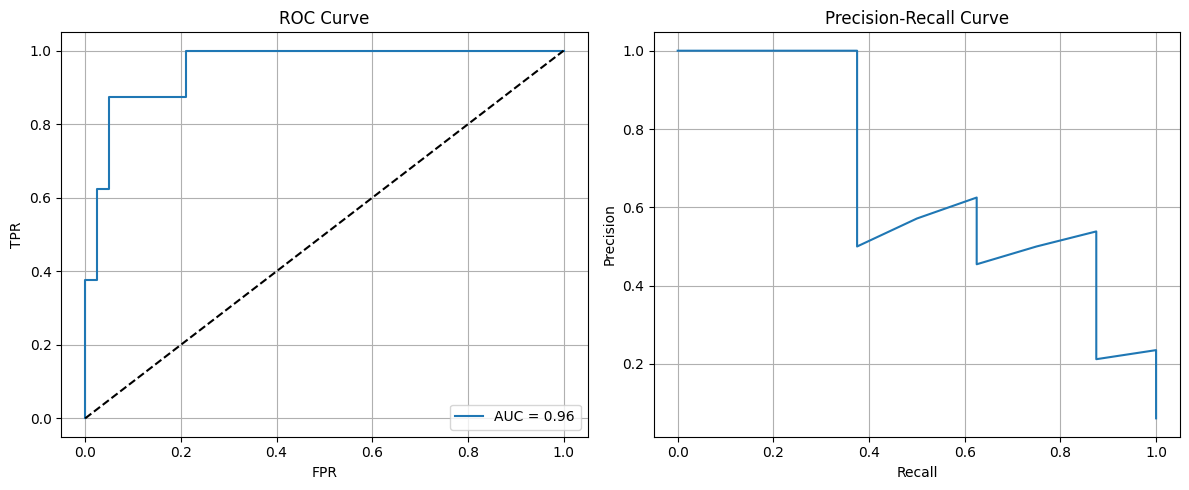

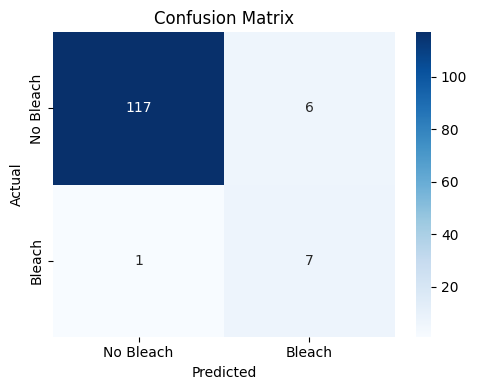


--- Fold 3 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       123
           1       0.71      0.62      0.67         8

    accuracy                           0.96       131
   macro avg       0.85      0.80      0.82       131
weighted avg       0.96      0.96      0.96       131

Best Threshold: 0.32
F2 Score: 0.6410
AUC Score: 0.8110
Confusion Matrix:
[[121   2]
 [  3   5]]


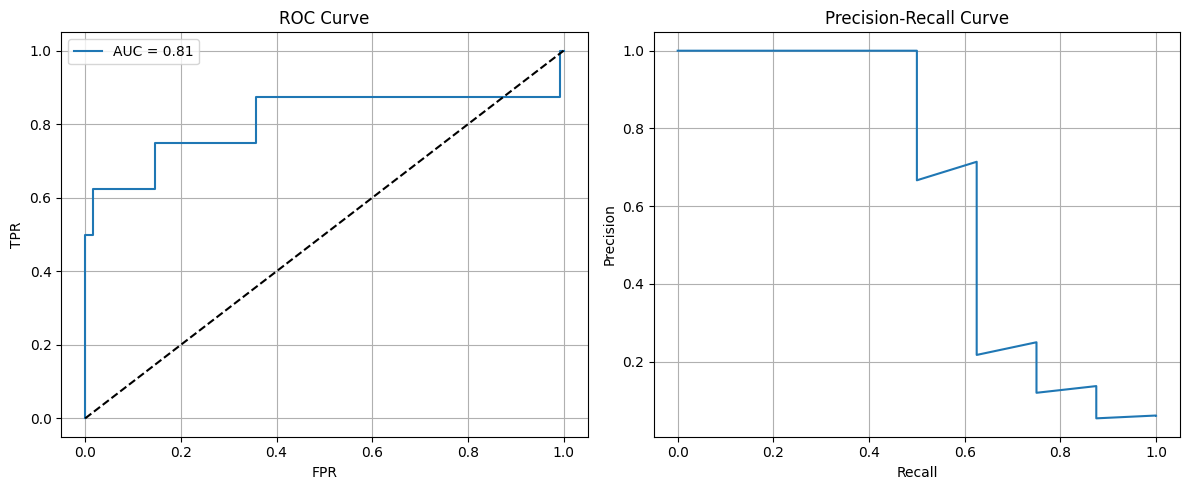

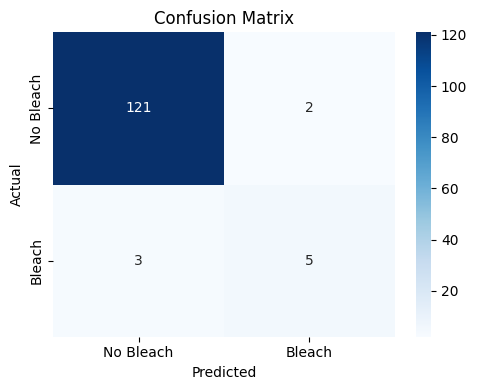


--- Fold 4 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       123
           1       0.67      1.00      0.80         8

    accuracy                           0.97       131
   macro avg       0.83      0.98      0.89       131
weighted avg       0.98      0.97      0.97       131

Best Threshold: 0.15
F2 Score: 0.9091
AUC Score: 0.9868
Confusion Matrix:
[[119   4]
 [  0   8]]


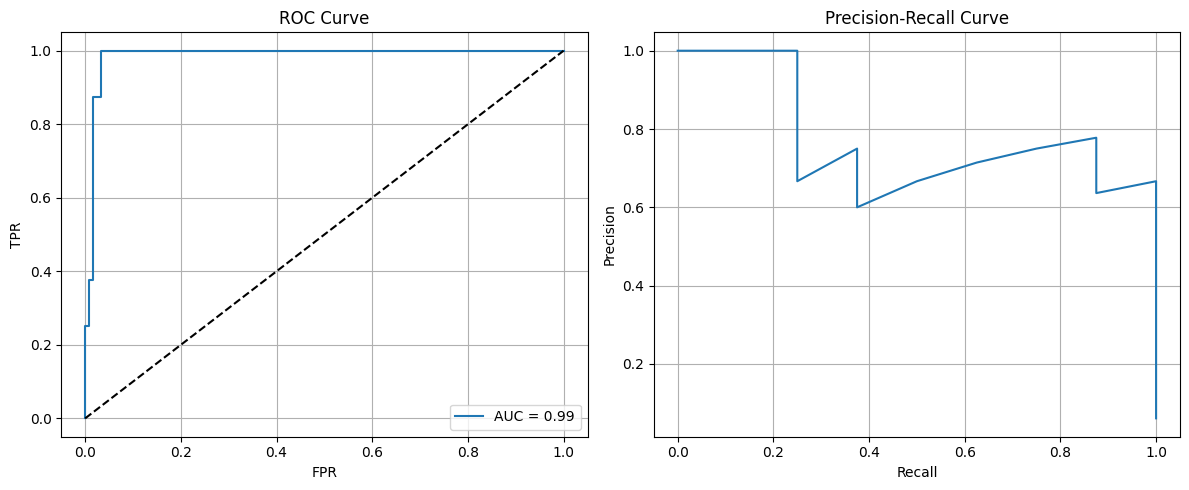

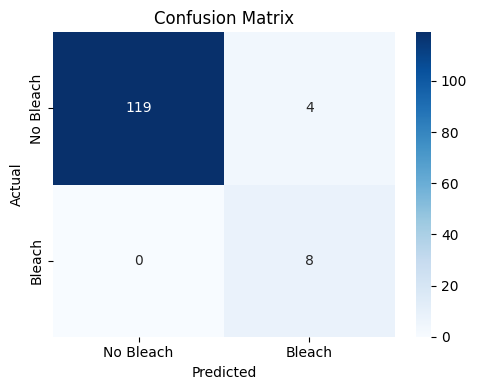


--- Fold 5 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       123
           1       0.54      0.88      0.67         8

    accuracy                           0.95       131
   macro avg       0.76      0.91      0.82       131
weighted avg       0.96      0.95      0.95       131

Best Threshold: 0.23
F2 Score: 0.7778
AUC Score: 0.9634
Confusion Matrix:
[[117   6]
 [  1   7]]


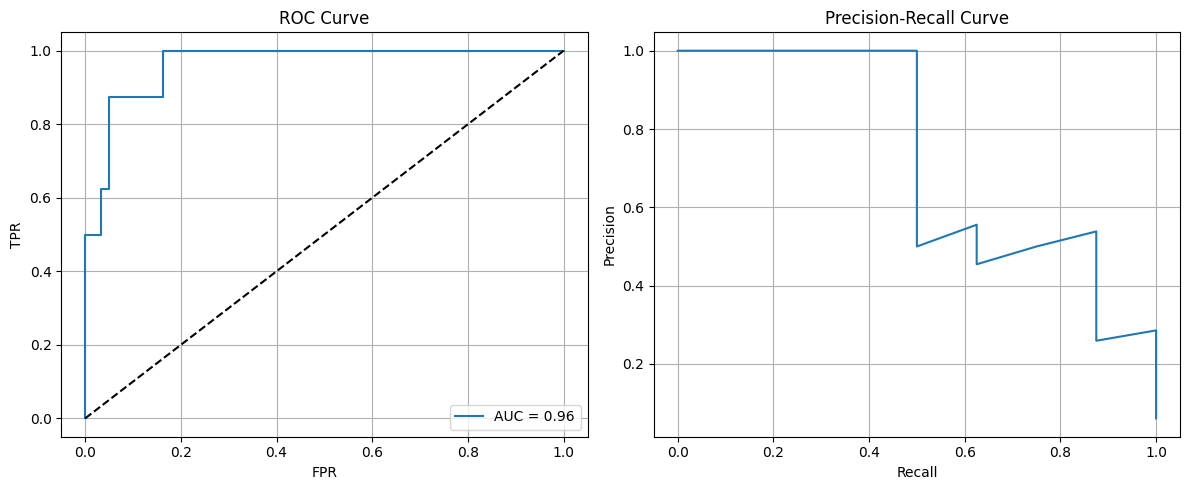

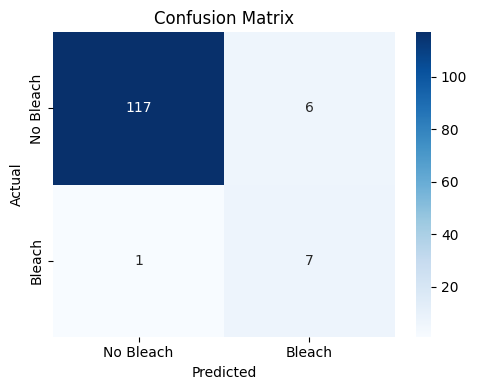


--- Fold 6 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       123
           1       0.58      0.88      0.70         8

    accuracy                           0.95       131
   macro avg       0.79      0.92      0.84       131
weighted avg       0.97      0.95      0.96       131

Best Threshold: 0.25
F2 Score: 0.7955
AUC Score: 0.9756
Confusion Matrix:
[[118   5]
 [  1   7]]


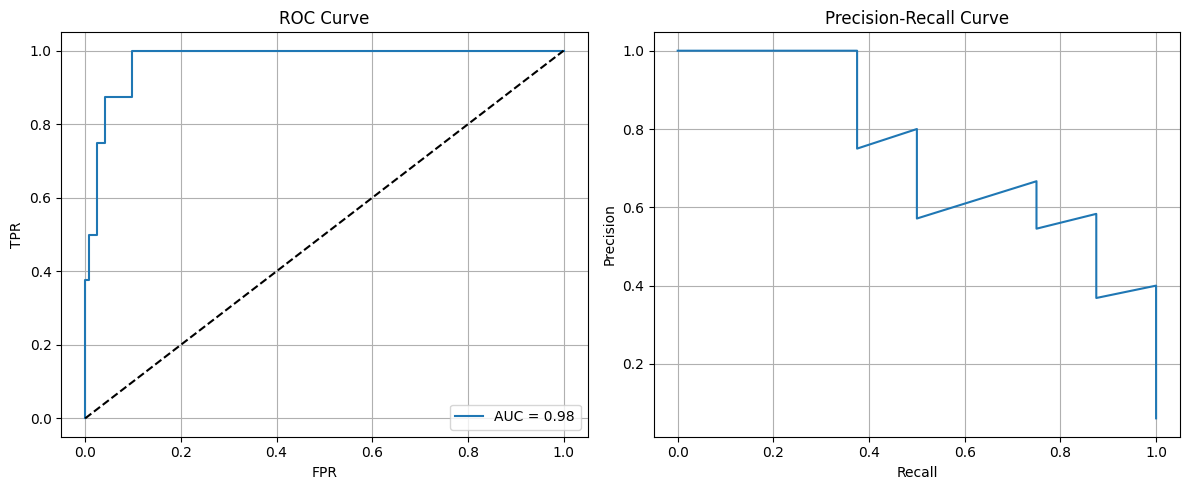

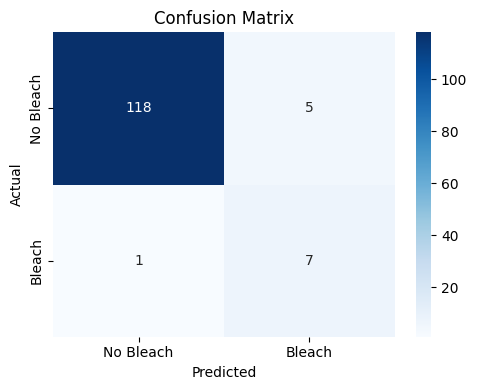


--- Fold 7 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       123
           1       0.41      0.88      0.56         8

    accuracy                           0.92       131
   macro avg       0.70      0.90      0.76       131
weighted avg       0.96      0.92      0.93       131

Best Threshold: 0.10
F2 Score: 0.7143
AUC Score: 0.8567
Confusion Matrix:
[[113  10]
 [  1   7]]


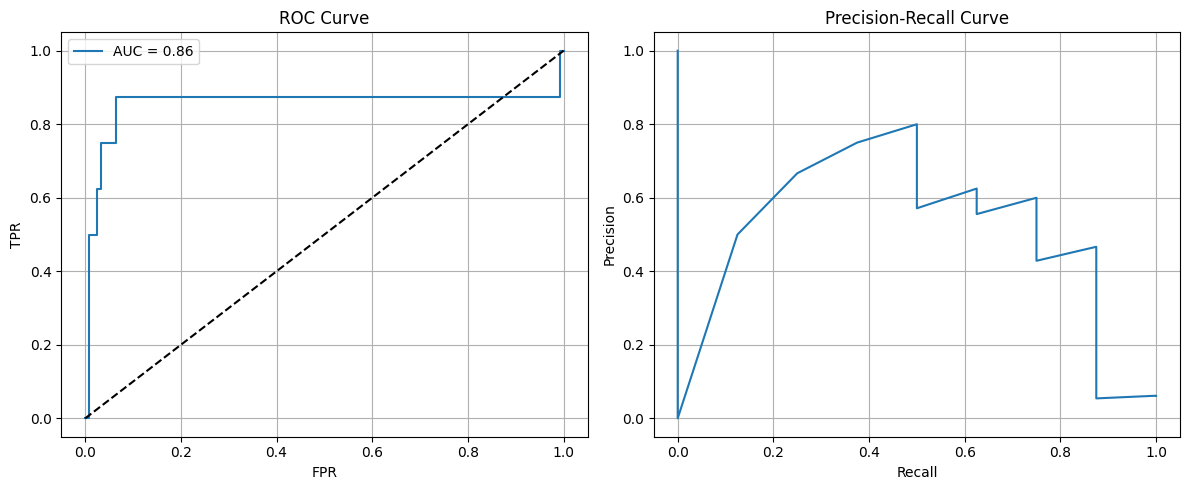

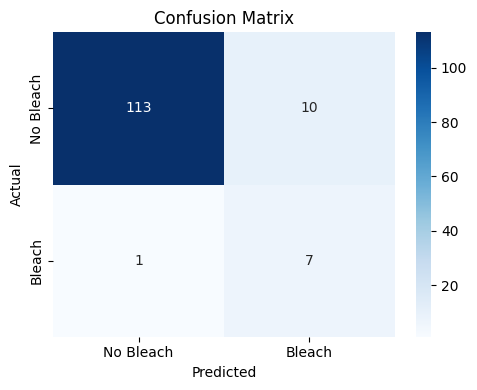


--- Fold 8 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       123
           1       0.75      0.75      0.75         8

    accuracy                           0.97       131
   macro avg       0.87      0.87      0.87       131
weighted avg       0.97      0.97      0.97       131

Best Threshold: 0.25
F2 Score: 0.7500
AUC Score: 0.9685
Confusion Matrix:
[[121   2]
 [  2   6]]


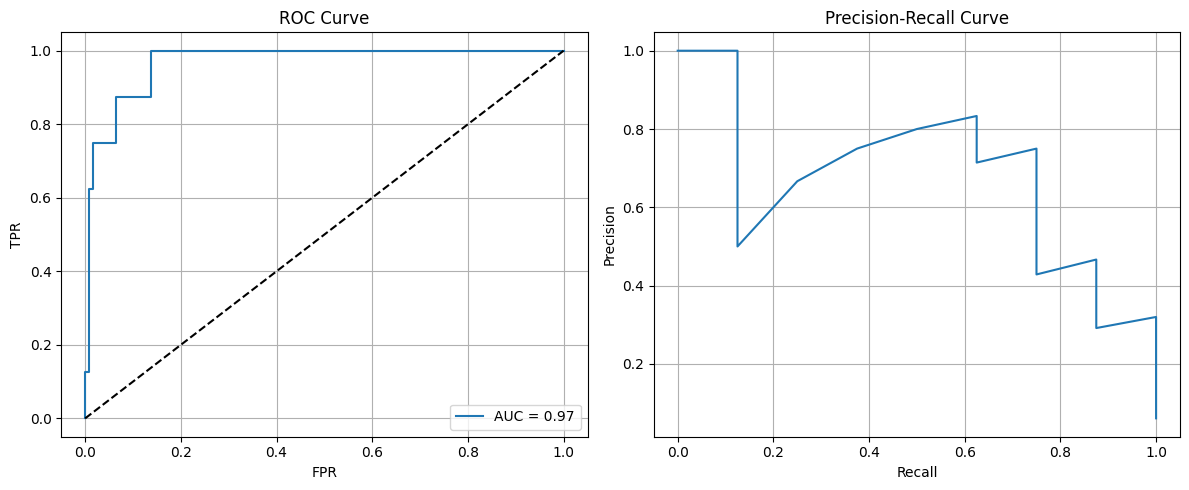

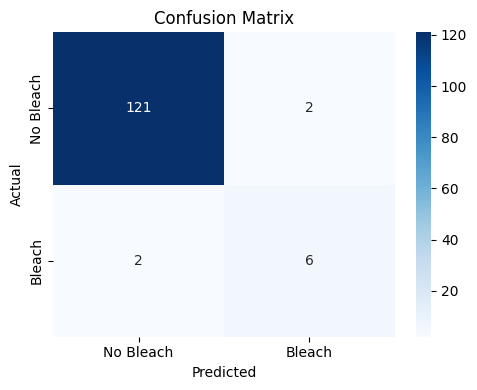


--- Fold 9 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       123
           1       0.60      0.86      0.71         7

    accuracy                           0.96       130
   macro avg       0.80      0.91      0.84       130
weighted avg       0.97      0.96      0.96       130

Best Threshold: 0.12
F2 Score: 0.7895
AUC Score: 0.9547
Confusion Matrix:
[[119   4]
 [  1   6]]


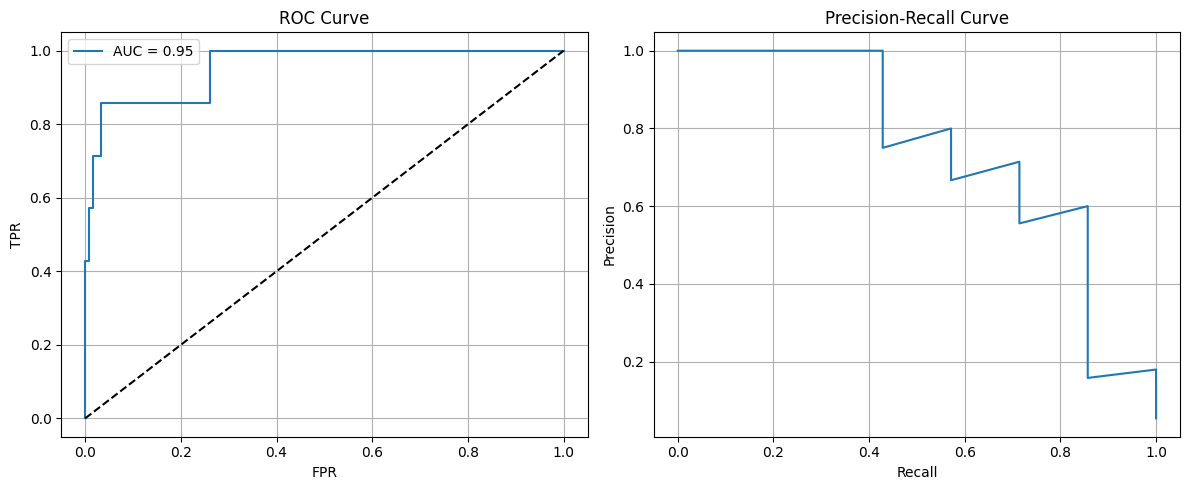

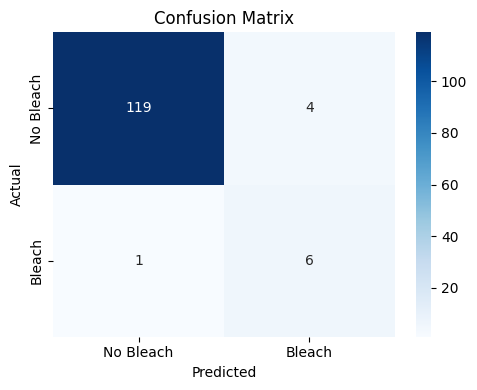


--- Fold 10 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       123
           1       1.00      0.71      0.83         7

    accuracy                           0.98       130
   macro avg       0.99      0.86      0.91       130
weighted avg       0.98      0.98      0.98       130

Best Threshold: 0.15
F2 Score: 0.7576
AUC Score: 0.9698
Confusion Matrix:
[[123   0]
 [  2   5]]


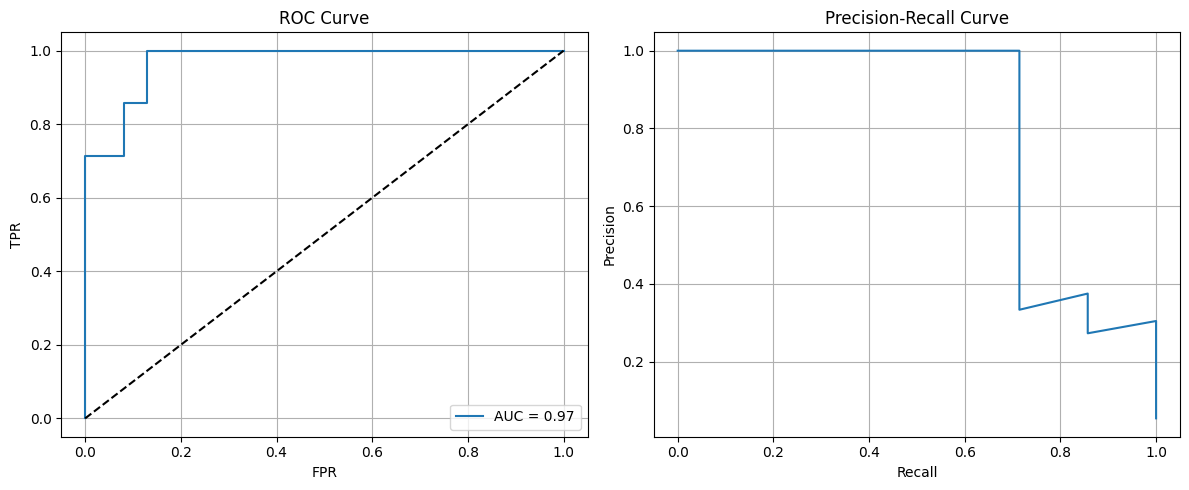

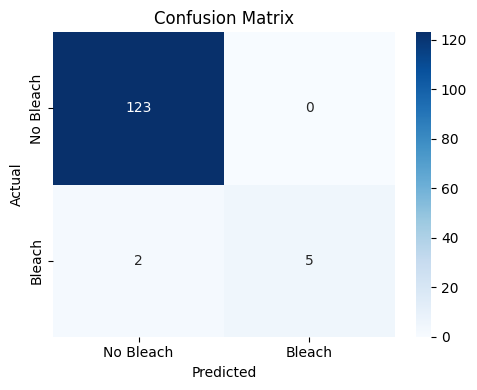


=== Cross-Validation Summary ===
Avg F2: 0.7553 ± 0.0743
Avg AUC: 0.9394 ± 0.0547
Best Thresholds: [0.19 0.15 0.32 0.15 0.23 0.25 0.1  0.25 0.12 0.15]


In [19]:
X, y = load_data('/Users/owlxshri/Desktop/coral reef/mlpr-project/statisticalinf/g4m copy.csv')
X_scaled, _, _ = normalize_and_reshape(X)
cross_validate_lstm(X_scaled, y)
